In [1]:
!pip install git+https://github.com/huseinzol05/malaya.git

  Cloning https://github.com/huseinzol05/malaya.git to /tmp/pip-req-build-irfkmc9a
  Running command git clone --filter=blob:none --quiet https://github.com/huseinzol05/malaya.git /tmp/pip-req-build-irfkmc9a
  Resolved https://github.com/huseinzol05/malaya.git to commit 06a92a8e608bf136e8dbe93469e32d4cf9b8d53f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import malaya
from gensim.models import Word2Vec
import fasttext
import nltk
nltk.download('punkt')
import re
from wordcloud import WordCloud

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import itertools

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv("/kaggle/input/depress-suicide-cp/depressed_suicide.csv")

In [4]:
df.head()

,Unnamed: 0.1,Unnamed: 0,text,class,translated_text
0,0,0,Am I weird I don't get affected by compliments...,0,Adakah saya pelik saya tidak terpengaruh denga...
1,1,1,Finally 2020 is almost over... So I can never ...,0,"Akhirnya 2020 hampir berakhir ... Oleh itu, sa..."
2,2,2,i need helpjust help me im crying so hard,1,Saya memerlukan pertolongan untuk menolong say...
3,3,3,It ends tonight.I can’t do it anymore. \nI quit.,1,Ia berakhir malam ini. Saya tidak dapat melaku...
4,4,4,I took the rest of my sleeping pills and my pa...,1,Saya mengambil sisa pil tidur saya dan ubat pe...


In [5]:
df = df.drop(["Unnamed: 0.1", "Unnamed: 0"], axis = 1)

In [6]:
df['translated_text'] = df['translated_text'].astype(str)

In [7]:
# Plot the validation and training data separately

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(1, len(history.history['loss']) + 1)

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [8]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [9]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [10]:
# Split the dataset into training and temporary sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['translated_text'], df['class'], test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Print the sizes of the splits
print("Training set size:", len(train_texts))
print("Validation set size:", len(val_texts))
print("Test set size:", len(test_texts))

Training set size: 11330
Validation set size: 1416
Test set size: 1417


In [11]:
from transformers import BertTokenizer, TFBertForSequenceClassification

bert = TFBertForSequenceClassification.from_pretrained('malay-huggingface/bert-tiny-bahasa-cased', from_pt=True)
bert_tokenizer = BertTokenizer.from_pretrained(
    'malay-huggingface/bert-tiny-bahasa-cased',
    do_lower_case = False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), # Adam optimizer with 0.00002 learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Loss function for binary classification
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]) # Accuracy as metrics to evaluate overfitting

In [13]:
# to tokenize and convert the text data into tensors compatible with TensorFlow
train_encodings_bert = bert_tokenizer.batch_encode_plus(train_texts, truncation=True, 
                                                        padding=True, max_length=128, return_tensors='tf')
val_encodings_bert = bert_tokenizer.batch_encode_plus(val_texts, truncation=True, 
                                                      padding=True, max_length=128, return_tensors='tf')
test_encodings_bert = bert_tokenizer.batch_encode_plus(test_texts, truncation=True, 
                                                       padding=True, max_length=128, return_tensors='tf')

In [14]:
train_dataset_bert = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_encodings_bert['input_ids'], 'attention_mask': train_encodings_bert['attention_mask']},
    train_labels
))

val_dataset_bert = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_encodings_bert['input_ids'], 'attention_mask': val_encodings_bert['attention_mask']},
    val_labels
))

In [15]:
tf.autograph.experimental.do_not_convert

tf.random.set_seed(42)

bert_history = bert.fit(train_dataset_bert.shuffle(1000).batch(16),
                      validation_data=val_dataset_bert.batch(16),
                      epochs=10)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report 

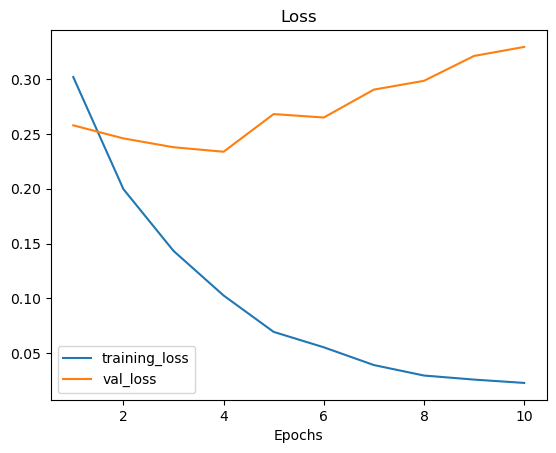

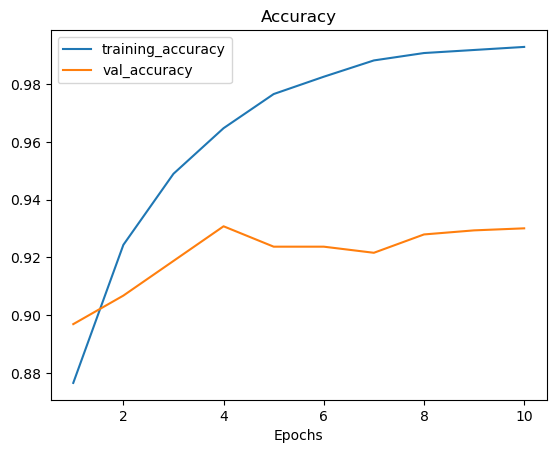

In [16]:
plot_loss_curves(bert_history)

In [17]:
# Create a test dataset
test_input_ids_bert = tf.constant(test_encodings_bert['input_ids'])
test_attention_mask_bert = tf.constant(test_encodings_bert['attention_mask'])
test_dataset_bert = tf.data.Dataset.from_tensor_slices((test_input_ids_bert, test_attention_mask_bert)).batch(16)

In [18]:
tf.autograph.experimental.do_not_convert
test_predictions = bert.predict(test_dataset_bert)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
89/89 [==============================] - 3s 23ms/step


In [19]:
bert_result = [np.argmax(val) for val in test_predictions[0]]

In [20]:
calculate_results(test_labels, bert_result)

{'accuracy': 90.19054340155257,
 'precision': 0.9014489813194272,
 'recall': 0.9019054340155258,
 'f1': 0.9015680059634315}

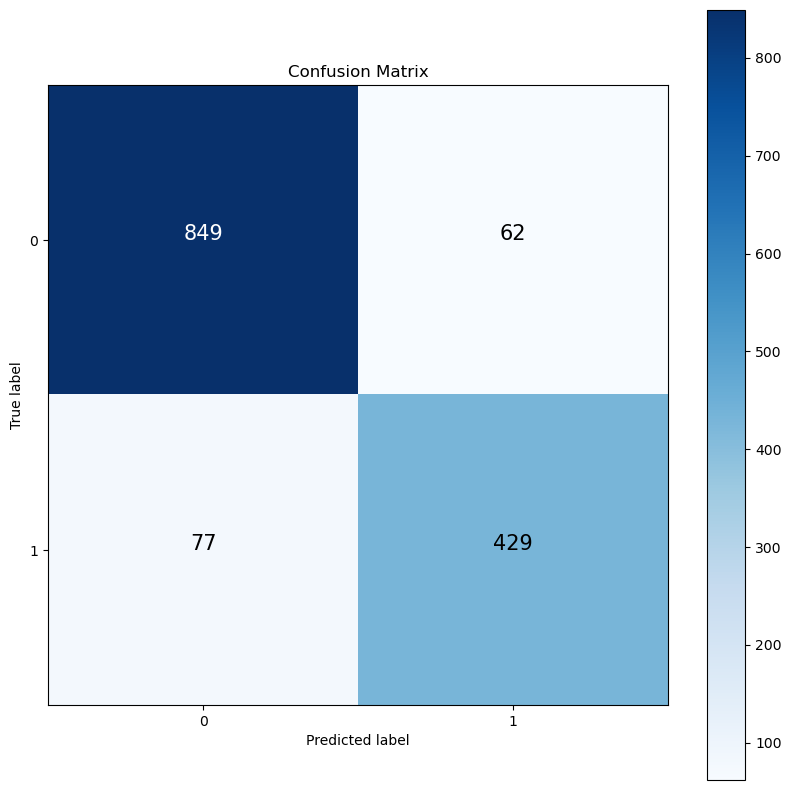

In [21]:
make_confusion_matrix(test_labels, bert_result)

In [22]:
from transformers import TFXLNetForSequenceClassification, XLNetTokenizer

xlnet = TFXLNetForSequenceClassification.from_pretrained('malay-huggingface/xlnet-tiny-bahasa-cased', from_pt=True)
xlnet_tokenizer = XLNetTokenizer.from_pretrained(
    'malay-huggingface/xlnet-tiny-bahasa-cased',
    do_lower_case = False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing TFXLNetForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFXLNetForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

In [23]:
xlnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), # Adam optimizer with 0.00002 learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Loss function for binary classification
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]) # Accuracy as metrics to evaluate overfitting

In [24]:
# Tokenize and encode the training text sequences
train_encodings_xlnet = xlnet_tokenizer.batch_encode_plus(train_texts, truncation=True, padding=True, max_length=128,
                                              return_tensors='tf')

# Tokenize and encode the validation text sequences
val_encodings_xlnet = xlnet_tokenizer.batch_encode_plus(val_texts, truncation=True, padding=True, max_length=128,
                                            return_tensors='tf')

# Tokenize and encode the test text sequences
test_encodings_xlnet = xlnet_tokenizer.batch_encode_plus(test_texts, truncation=True, padding=True, max_length=128,
                                             return_tensors='tf')

In [25]:
train_dataset_xlnet = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_encodings_xlnet['input_ids'], 'attention_mask': train_encodings_xlnet['attention_mask']},
    train_labels
))

val_dataset_xlnet = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_encodings_xlnet['input_ids'], 'attention_mask': val_encodings_xlnet['attention_mask']},
    val_labels
))

In [26]:
tf.autograph.experimental.do_not_convert

tf.random.set_seed(42)

xlnet_history = xlnet.fit(train_dataset_xlnet.shuffle(1000).batch(16),
                      validation_data=val_dataset_xlnet.batch(16),
                      epochs=10)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report 

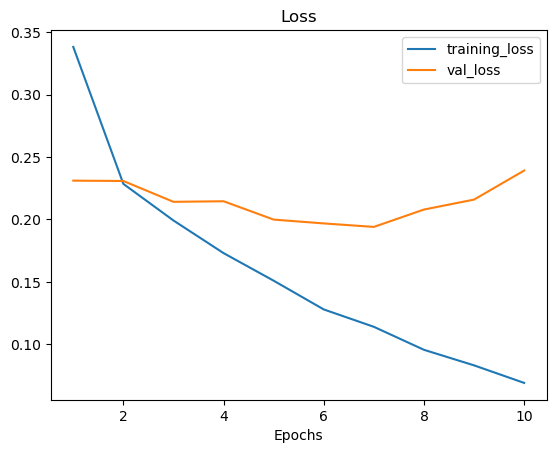

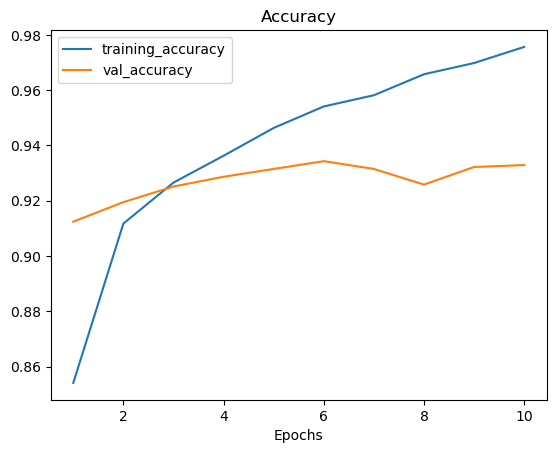

In [27]:
plot_loss_curves(xlnet_history)

In [28]:
# Create a test dataset
test_input_ids_xlnet = tf.constant(test_encodings_xlnet['input_ids'])
test_attention_mask_xlnet = tf.constant(test_encodings_xlnet['attention_mask'])
test_dataset_xlnet = tf.data.Dataset.from_tensor_slices((test_input_ids_xlnet, test_attention_mask_xlnet)).batch(16)

In [29]:
tf.autograph.experimental.do_not_convert
test_predictions_xlnet = xlnet.predict(test_dataset_xlnet)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
89/89 [==============================] - 3s 23ms/step


In [30]:
xlnet_result = [np.argmax(val) for val in test_predictions_xlnet[0]]

In [31]:
calculate_results(test_labels, xlnet_result)

{'accuracy': 85.53281580804517,
 'precision': 0.8719412105860979,
 'recall': 0.8553281580804517,
 'f1': 0.8463996069045641}

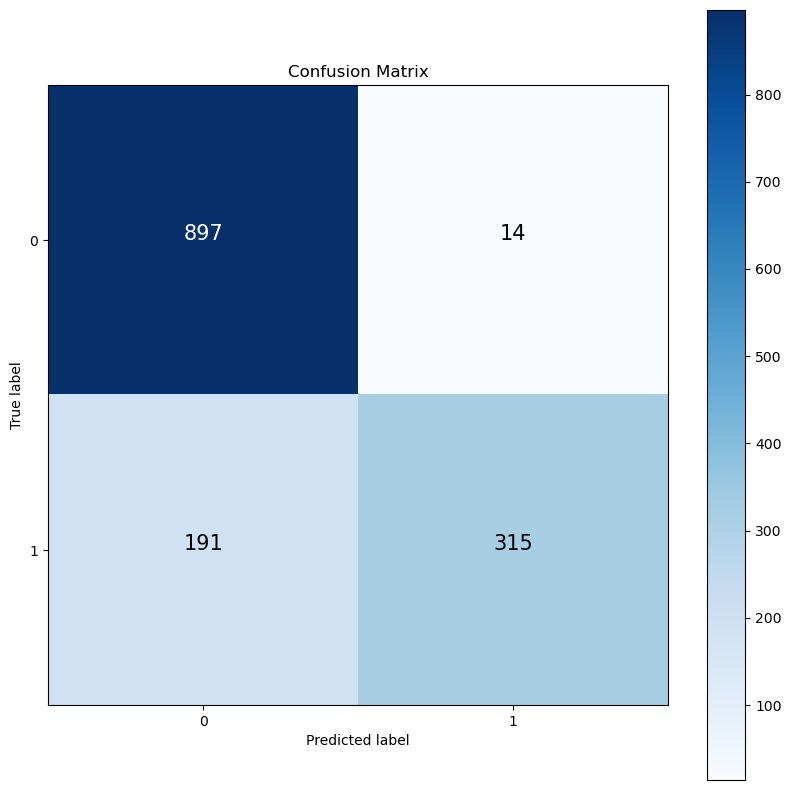

In [32]:
make_confusion_matrix(test_labels, xlnet_result)

In [33]:
# Step 1: Preprocess the text
def preprocess_text(text):
    inputs = bert_tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length = 128)
    return inputs

# Step 2: Make predictions
def predict_sentiment(text):
    inputs = preprocess_text(text)
    outputs = bert(**inputs)
    logits = outputs.logits
    probabilities = tf.nn.softmax(logits, axis=1)
    probability_of_suicidal_text = probabilities.numpy()[0][1]
    
    if probability_of_suicidal_text > 0.5:
        return "suicidal"
    else:
        return "non-suicidal"

In [34]:
# Use the model to predict an unseen text
unseen_text = "Aku terasa nak mati. Sudah putus asa terhadap hidup saya. Sesiapa boleh tolong?"
prediction = predict_sentiment(unseen_text)

print("Is it suicidal texts?:", prediction)

Is it suicidal texts?: suicidal


In [35]:
# Use the model to predict an unseen text
unseen_text2 = "Aku sgt gembira hari ni. Dpt kerja baru dan hati pun ringan"
prediction2 = predict_sentiment(unseen_text2)

print("Is it suicidal texts?:", prediction2)

Is it suicidal texts?: non-suicidal


In [36]:
# Use the model to predict an unseen text
unseen_text3 = "Hari ini adalah hari yang penuh kebahagiaan! Senyuman tak pernah lekang dari wajahku. Hati berasa ringan dan bersyukur akan kegembiraan yang mengalir dalam setiap detik."
prediction3 = predict_sentiment(unseen_text3)

print("Is it suicidal texts?:", prediction3)

Is it suicidal texts?: non-suicidal


In [37]:
# Use the model to predict an unseen text
unseen_text4 = "Syukur alhamdulillah! Perasaan bahagia mengalir dalam diriku. Hati riang dengan kegembiraan tiada tara. Semua ini membuat hidup begitu indah dan bererti."
prediction4 = predict_sentiment(unseen_text4)

print("Is it suicidal texts?:", prediction4)

Is it suicidal texts?: non-suicidal


In [38]:
# Use the model to predict an unseen text
unseen_text5 = "Terasa nak tamatkan hidupku. Sdh tidak harap utk hidup kat dunia ni. Takda org akan faham rasaku"
prediction5 = predict_sentiment(unseen_text5)

print("Is it suicidal texts?:", prediction5)

Is it suicidal texts?: suicidal


In [40]:
# Use the model to predict an unseen text
unseen_text6 = "Saya mengambil sisa pil tidur saya dan ubat penahan sakit saya. Saya tidak sabar untuk berakhir, saya telah berjuang selama 6 tahun yang lalu dan akhirnya saya mengakhirinya."
prediction6 = predict_sentiment(unseen_text6)

print("Is it suicidal texts?:", prediction6)

Is it suicidal texts?: suicidal
